# Homework 1

**Course**: FFR120 - Simulation of Complex Systems

**Author**: Artur Gasparyan

**Assignment**: Homework 1 - Option 4

In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim

In [2]:
rng = np.random.default_rng()
save_file = True
framerate_fast = 10
framerate_medium = 5
framerate_slow = 2
gif_writer_fast = anim.PillowWriter(fps=framerate_fast)
gif_writer_medium = anim.PillowWriter(fps=framerate_medium)
gif_writer_slow = anim.PillowWriter(fps=framerate_slow)

## Exercise 4.1 

In [3]:
import math

def decimal_to_binary_array(dec, width):
    if width is None:
        if dec == 0:
            width = 1
        else:
            width = 1 + math.floor(math.log2(dec))
    
    array = np.zeros(shape=(width,), dtype='uint8')
    
    for i in range(width-1, -1, -1):
        dec, array[i] = divmod(dec, 2)

    return array


In [4]:
def create_parent_generation(n_cells, rule_nr, rng):
    if rule_nr in (90, 30):
        parent_generation = np.zeros((n_cells,))
        parent_generation[n_cells//2] = 1
        
    else:
        parent_generation = rng.integers(0, 2, size=(n_cells,))
        
    return parent_generation


def create_grid_1d(rule_nr, n_cells, n_generations, rng):
    grid = np.zeros(shape=(n_generations, n_cells), dtype='uint8')
    grid[0, :] = create_parent_generation(n_cells, rule_nr, rng) 
    return grid


def decode_1d_rule(rule_number):
    binary_numbers = [
        (1, 1, 1), (1, 1, 0), (1, 0, 1), (1, 0, 0),
        (0, 1, 1), (0, 1, 0), (0, 0, 1), (0, 0, 0)
    ]

    rule = dict()
    num = rule_number
    for i in range(8):
        num, rem = divmod(num, 2)
        rule[binary_numbers[-i-1]] = rem

    return rule


def update_grid_1d(grid, n_cells, rules, rng):
    grid = np.roll(grid, 1, 0)
    for i in range(1, n_cells-1):
        pattern = grid[1, i-1:i+2]
        grid[0, i] = rules[tuple(pattern)]

    left_pattern = np.zeros(shape=(3,))
    left_pattern[0] = grid[1, -1]
    left_pattern[1:] = grid[1, :2]

    right_pattern = np.zeros(shape=(3,))
    right_pattern[-1] = grid[1, 0]
    right_pattern[:2] = grid[1, -2:]

    grid[0, 0] = rules[tuple(left_pattern)]
    grid[0, -1] = rules[tuple(right_pattern)]

    return grid


In [5]:
def run_simulation_1d(n_cells, n_generations, rule_nr, rng):
    rules = decode_1d_rule(rule_number=rule_nr)
    grid = create_grid_1d(rule_nr, n_cells, n_generations, rng)
    history = []

    for gen in range(n_generations):
        grid = update_grid_1d(grid, n_cells, rules, rng)
        history.append(grid)

    return history


In [6]:
def render_grid(time, history, img):
    img.set_array(history[time])
    return img,


def create_animation(history, framerate):
    fig = plt.figure()
    img = plt.imshow(history[0], interpolation='none', animated=True)
    animation = anim.FuncAnimation(fig=fig, func=render_grid, frames=len(history), interval=1000/framerate, fargs=(history,img), blit=True, repeat=False)    
    return animation


def animate_simulation(name, history, framerate, writer, save_file):
    animation = create_animation(history, framerate)
    if save_file:
        animation.save(f"./gifs/{name}.gif", writer=writer)
        
    return animation
    

In [7]:
n_cells = 80
n_generations = 80

<IPython.core.display.Javascript object>


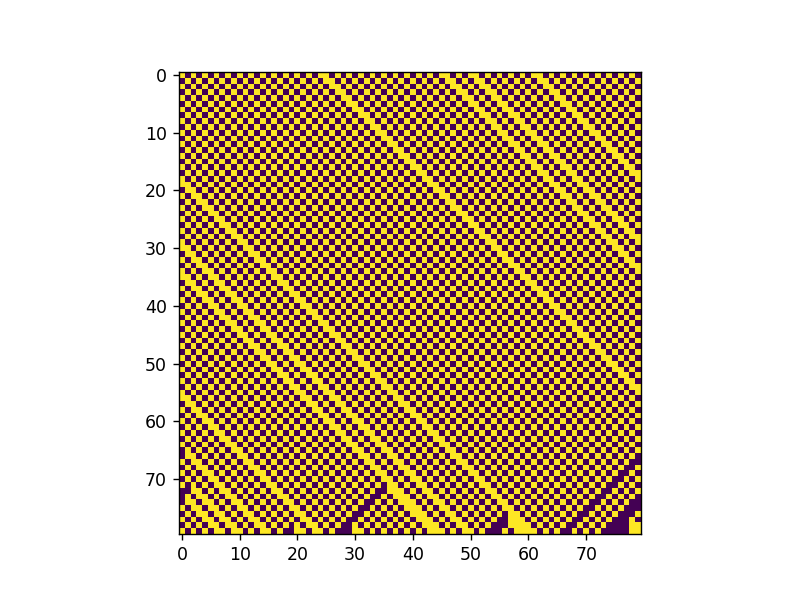

In [8]:
history_184 = run_simulation_1d(n_cells, n_generations, 184, rng)
animation_184 = animate_simulation("evolution-184", history_184, framerate_fast, gif_writer_fast, save_file)

<IPython.core.display.Javascript object>


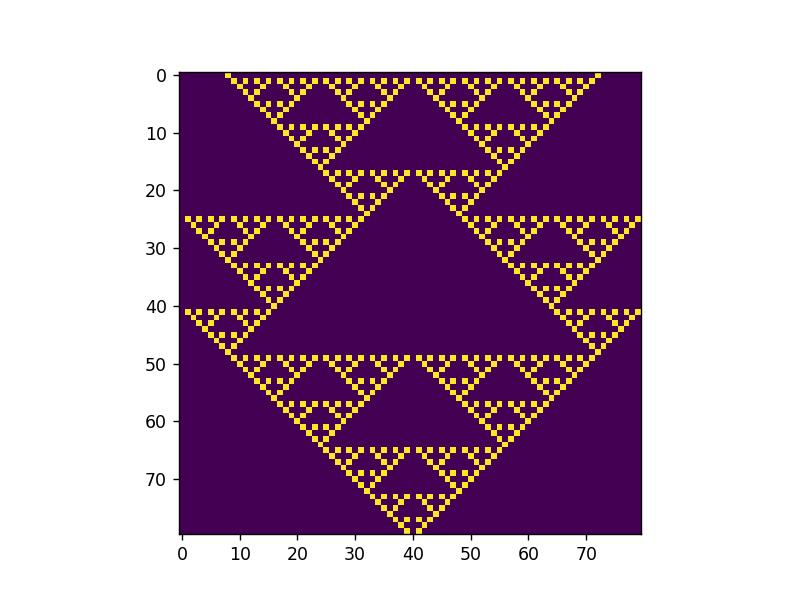

In [9]:
history_90 = run_simulation_1d(n_cells, n_generations, 90, rng)
animation_90 = animate_simulation("evolution-90", history_90, framerate_fast, gif_writer_fast, save_file)

<IPython.core.display.Javascript object>


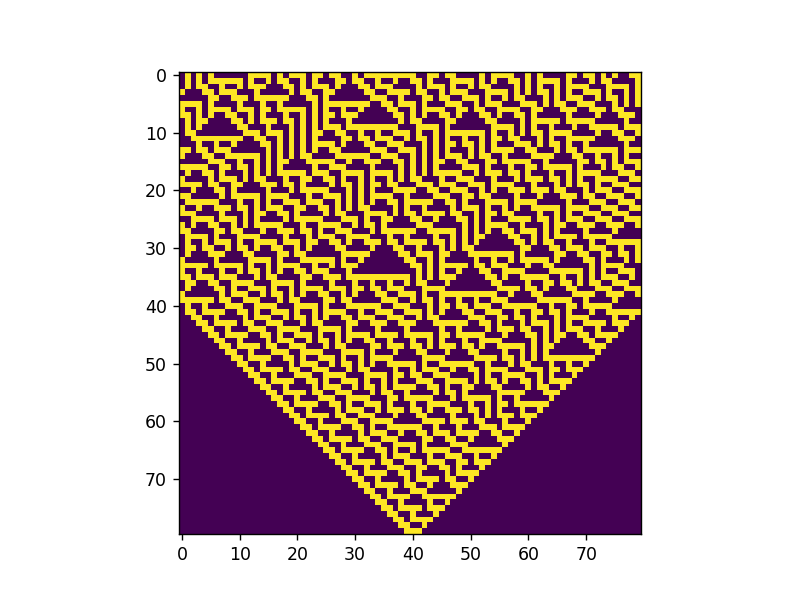

In [10]:
history_30 = run_simulation_1d(n_cells, n_generations, 30, rng)
animation_30 = animate_simulation("evolution-30", history_30, framerate_fast, gif_writer_fast, save_file)

<IPython.core.display.Javascript object>


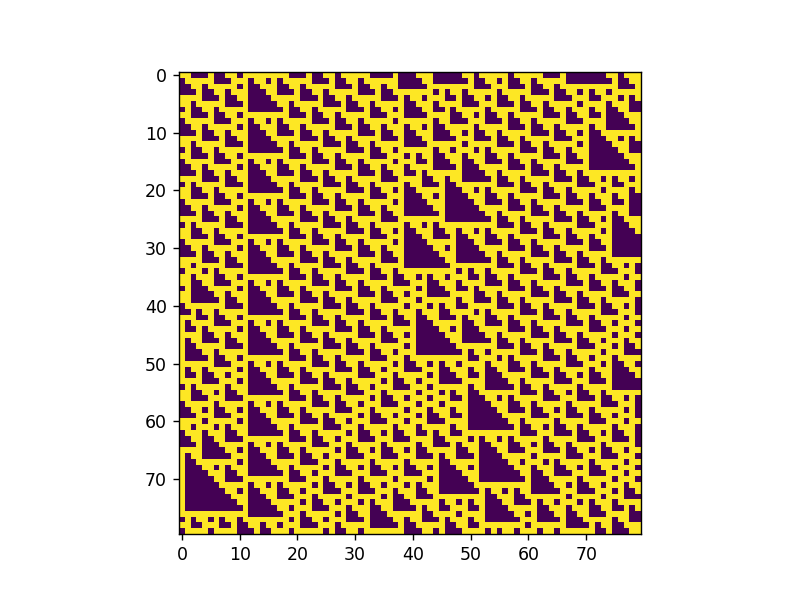

In [11]:
history_110 = run_simulation_1d(n_cells, n_generations, 110, rng)
animation_110 = animate_simulation("evolution-110", history_110, framerate_fast, gif_writer_fast, save_file)

<IPython.core.display.Javascript object>


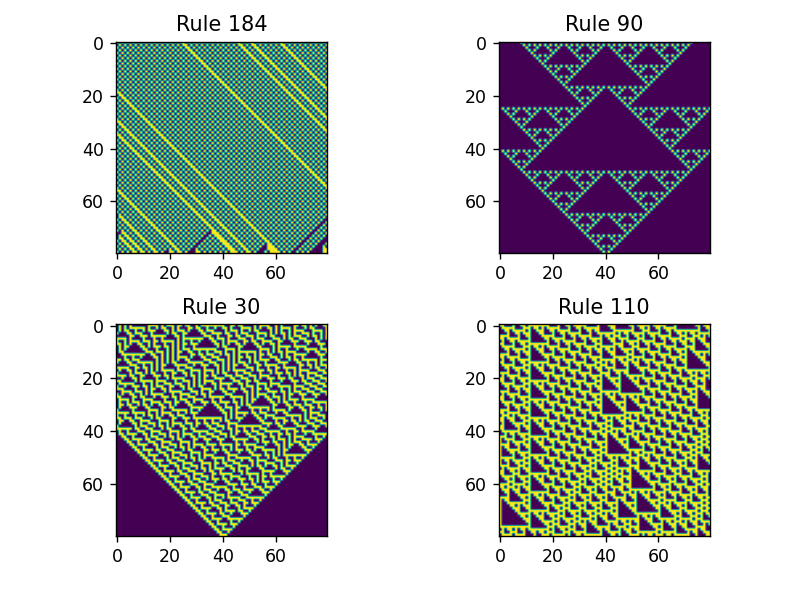

In [12]:
fig, axes = plt.subplots(2, 2)
histories = [history_184, history_90, history_30, history_110]
plt_names = ["Rule 184", "Rule 90", "Rule 30", "Rule 110"]
fig.tight_layout(pad=2)

for hist, ax, name in zip(histories, axes.flatten(), plt_names):
    ax.imshow(hist[-1])
    ax.set_title(name)
    

## Exercise 4.2

In [13]:
def create_grid(grid_size, rng):
    return rng.integers(0, 2, size=grid_size)
    

def enough_nbs_to_live(value, n_nbs):
    return n_nbs == 3 or (n_nbs == 2 and value)


def count_nbs(grid, grid_size, is_periodic_boundary):
    h, w = grid_size
    counts = np.zeros(shape=grid_size, dtype='uint8')
    
    if is_periodic_boundary:
        for y in range(h):
            for x in range(w):
                n_nbs = 0
                for nb_y in range(y-1, y+2):
                    nb_ym = nb_y % h
                    for nb_x in range(x-1, x+2):
                        nb_xm = nb_x % w
                        n_nbs += grid[nb_ym, nb_xm]
                        
                counts[y, x] = n_nbs - grid[y, x]
    
    else:
        for y in range(h):
            for x in range(w):
                n_nbs = 0
                for nb_y in range(max(y-1, 0), min(y+2, h)):
                    for nb_x in range(max(x-1, 0), min(x+2, w)):
                        n_nbs += grid[nb_y, nb_x]

                counts[y, x] = n_nbs - grid[y, x]
            
    return counts
            
            
def calculate_new_gen(grid, counts, rule_set=None):
    if rule_set is None:
        return ((counts==3) | ((counts==2) & (grid==1))).astype('uint8')
    
    else:
        new_grid = np.zeros(shape=grid.shape, dtype='uint8')
        
        for y in range(grid.shape[0]):
            for x in range(grid.shape[1]):
                new_grid[y, x] = rule_set[grid[y, x], counts[y, x]]

        return new_grid


def update_grid(grid, grid_size, is_periodic_boundary, rule_set=None):
    counts = count_nbs(grid, grid_size, is_periodic_boundary)
    new_gen = calculate_new_gen(grid, counts, rule_set=rule_set)
    
    return new_gen


def run_simulation(initial_grid, n_generations, is_periodic_boundary, rule_set=None):
    grid_size = initial_grid.shape
    grid = initial_grid
    history = [grid]
    
    for gen in range(1, n_generations):
        grid = update_grid(grid, grid_size, is_periodic_boundary, rule_set=rule_set)
        history.append(grid)
        
    return history

In [14]:
grid_size = 10, 10
n_generations = 20
initial_grid = create_grid(grid_size, rng)

<IPython.core.display.Javascript object>


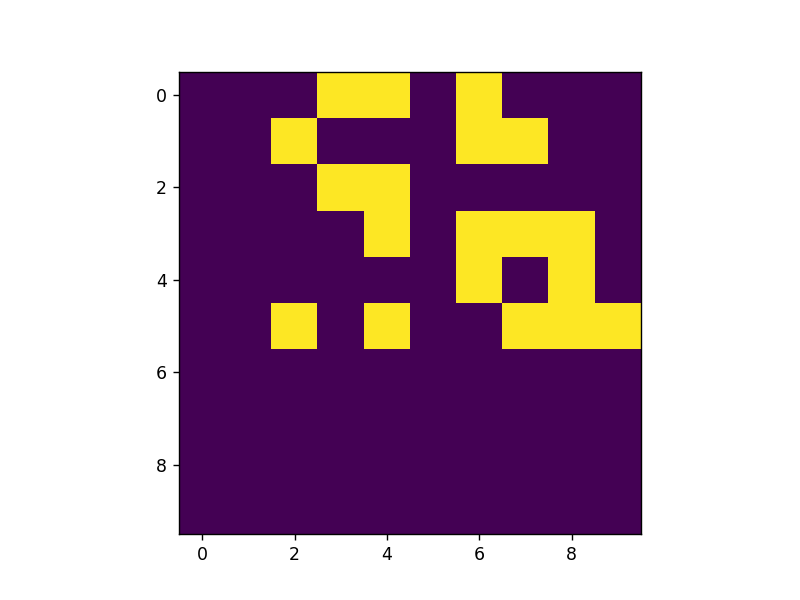

In [15]:
history_nonperiodic = run_simulation(initial_grid, n_generations, is_periodic_boundary=False)
animation_nonperiodic = animate_simulation(
    "evolution-nonperiodic", history_nonperiodic, framerate_medium, gif_writer_medium, save_file
)

<IPython.core.display.Javascript object>


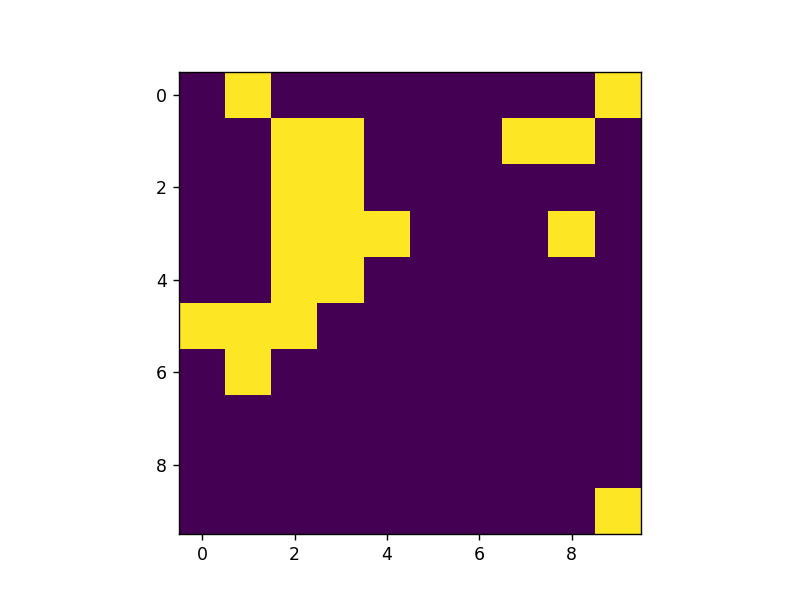

In [16]:
history_periodic = run_simulation(initial_grid, n_generations, is_periodic_boundary=True)
animation_periodic = animate_simulation(
    "evolution-periodic", history_periodic, framerate_medium, gif_writer_medium, save_file
)

## Exercise 4.3

<IPython.core.display.Javascript object>


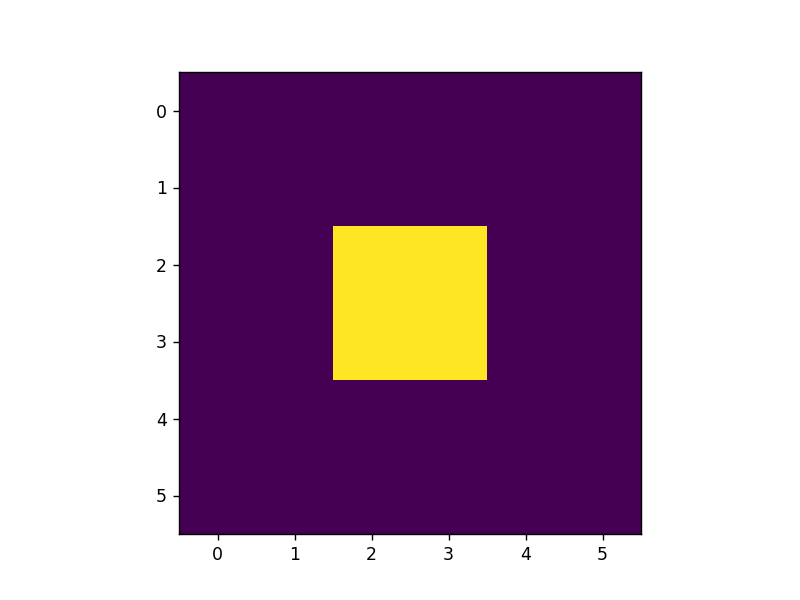

In [17]:
def simulate_block():
    grid = np.array([
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
    ], dtype='uint8')
    
    return run_simulation(grid, 2, False)

history_block = simulate_block()
animation_block = animate_simulation(
    "animation_block", history_block, framerate_medium, gif_writer_medium, save_file
)

<IPython.core.display.Javascript object>


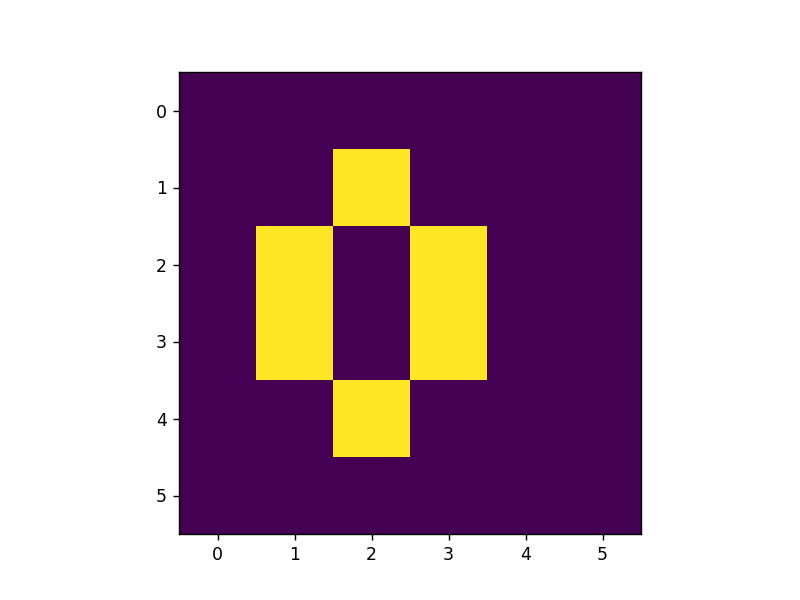

In [18]:
def simulate_beehive():
    grid = np.array([
        [0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 1, 0, 1, 0, 0],
        [0, 1, 0, 1, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
    ], dtype='uint8')
    
    return run_simulation(grid, 2, False)

history_beehive = simulate_beehive()
animation_beehive = animate_simulation(
    "animation_beehive", history_beehive, framerate_medium, gif_writer_medium, save_file
)

<IPython.core.display.Javascript object>


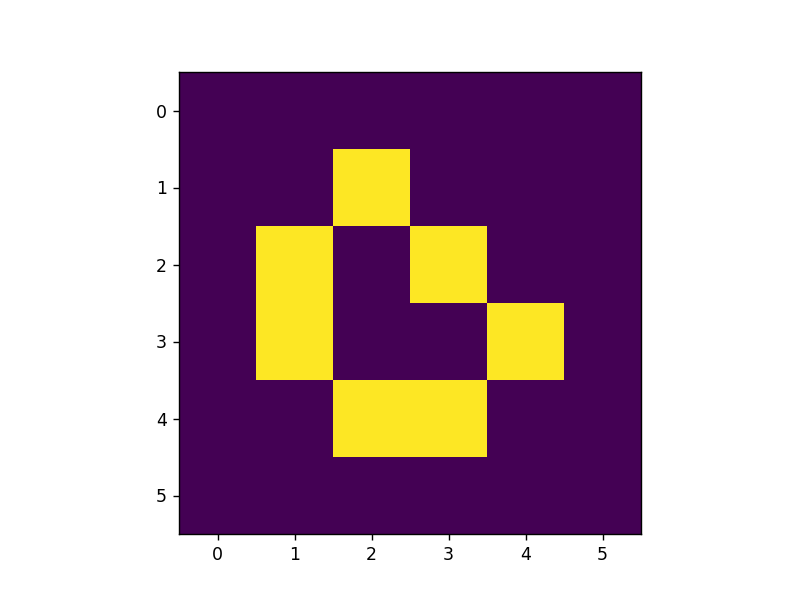

In [19]:
def simulate_loaf():
    grid = np.array([
        [0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 1, 0, 1, 0, 0],
        [0, 1, 0, 0, 1, 0],
        [0, 0, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0],
    ], dtype='uint8')
    
    return run_simulation(grid, 2, False)
    
history_loaf = simulate_loaf()
animation_loaf = animate_simulation(
    "animation_loaf", history_loaf, framerate_medium, gif_writer_medium, save_file
)

<IPython.core.display.Javascript object>


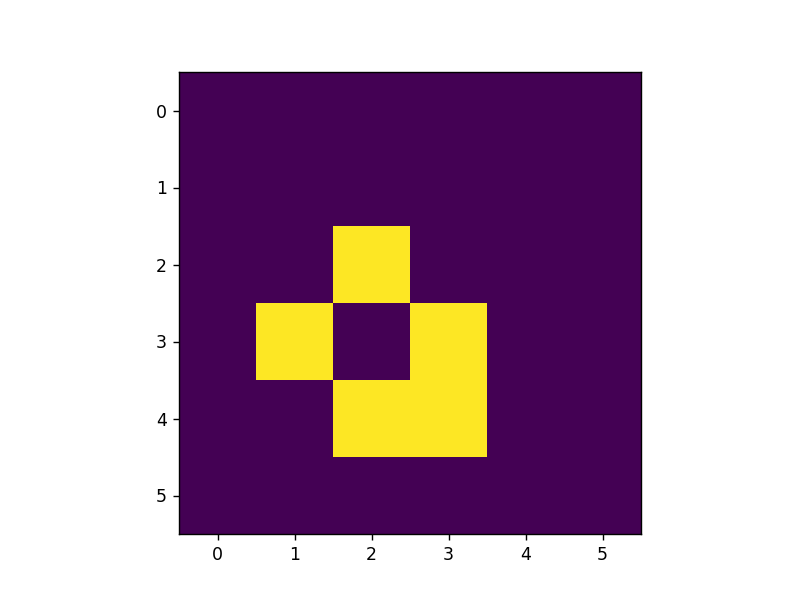

In [20]:
def simulate_boat():
    grid = np.array([
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 1, 0, 1, 0, 0],
        [0, 0, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0],
    ], dtype='uint8')
    
    return run_simulation(grid, 2, False)
    
history_boat = simulate_boat()
animation_boat = animate_simulation(
    "animation_boat", history_boat, framerate_medium, gif_writer_medium, save_file
)

<IPython.core.display.Javascript object>


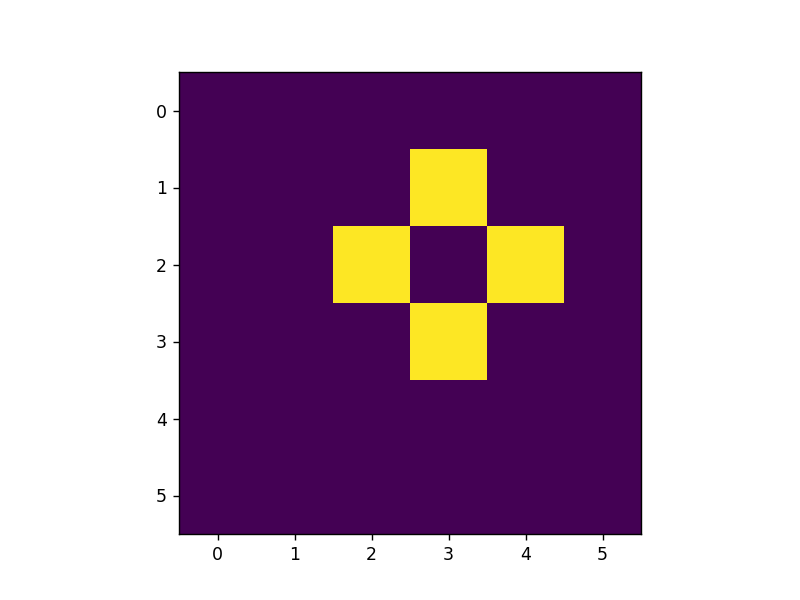

In [21]:
def simulate_tub():
    grid = np.array([
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 1, 0, 1, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
    ], dtype='uint8')
    
    return run_simulation(grid, 2, False)
    
history_tub = simulate_tub()
animation_tub = animate_simulation(
    "animation_tub", history_tub, framerate_medium, gif_writer_medium, save_file
)

## Exercise 4.4

<IPython.core.display.Javascript object>


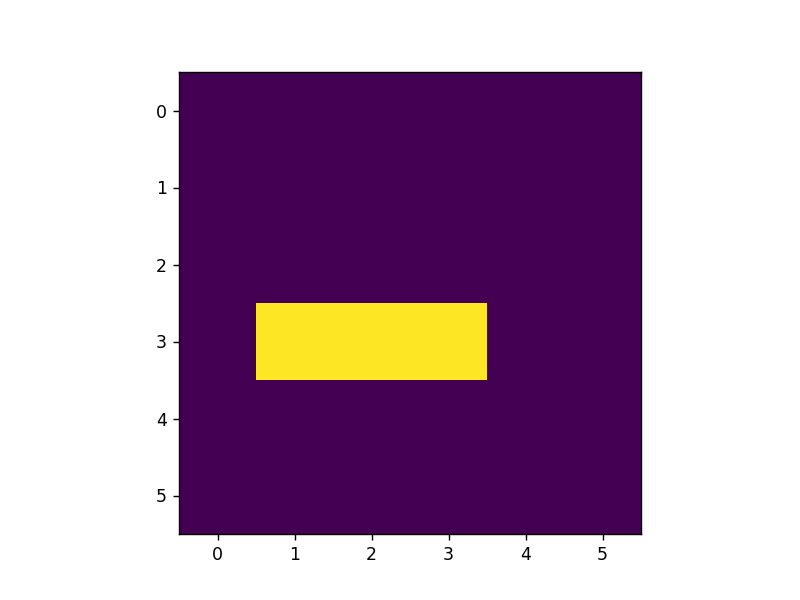

In [22]:
def simulate_blinker():
    grid = np.array([
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
    ], dtype='uint8')
    
    return run_simulation(grid, 4, False)
    
history_blinker = simulate_blinker()
animation_blinker = animate_simulation(
    "animation_blinker", history_blinker, framerate_medium, gif_writer_medium, save_file
)

<IPython.core.display.Javascript object>


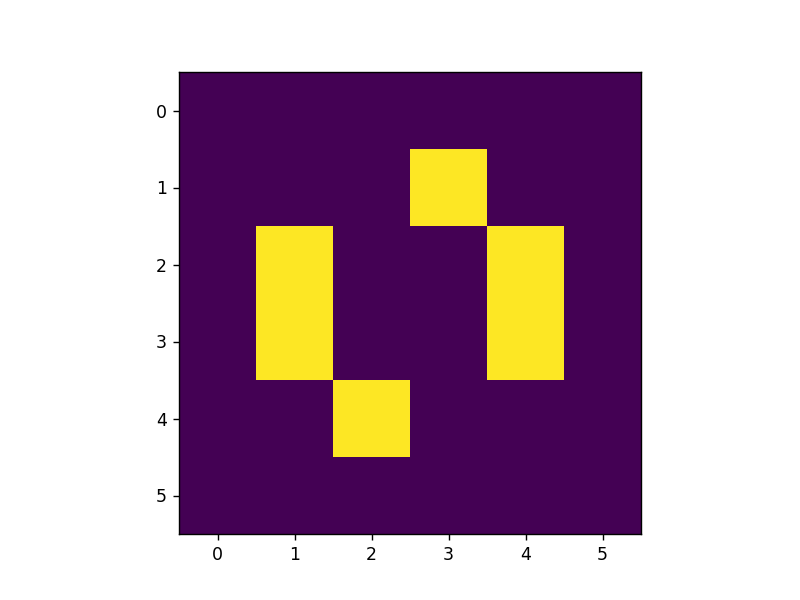

In [23]:
def simulate_toad():
    grid = np.array([
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 1, 0],
        [0, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
    ], dtype='uint8')
    
    return run_simulation(grid, 4, False)
    
history_toad = simulate_toad()
animation_toad = animate_simulation(
    "animation_toad", history_toad, framerate_medium, gif_writer_medium, save_file
)

<IPython.core.display.Javascript object>


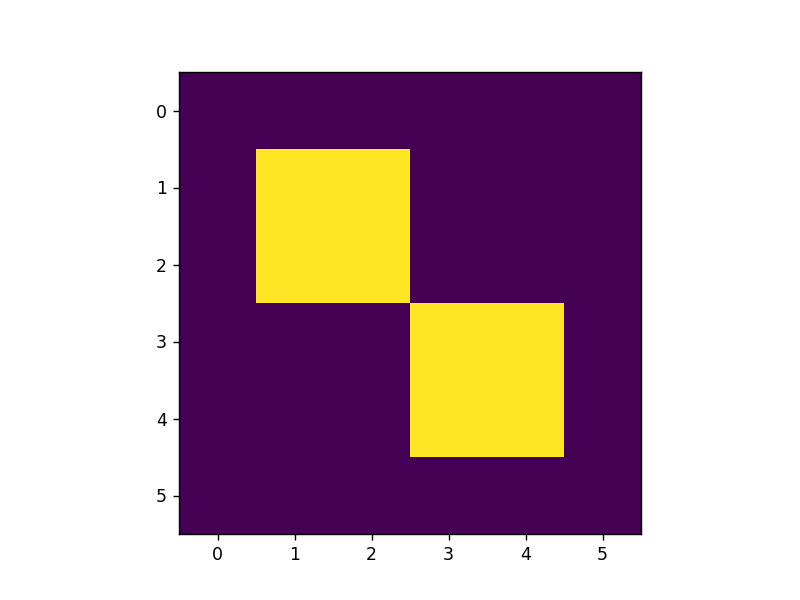

In [24]:
def simulate_beacon():
    grid = np.array([
        [0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 1, 0],
        [0, 0, 0, 0, 0, 0],
    ], dtype='uint8')
    
    return run_simulation(grid, 4, False)
    
history_beacon = simulate_beacon()
animation_beacon = animate_simulation(
    "animation_beacon", history_beacon, framerate_medium, gif_writer_medium, save_file
)

## Exercise 4.5

<IPython.core.display.Javascript object>


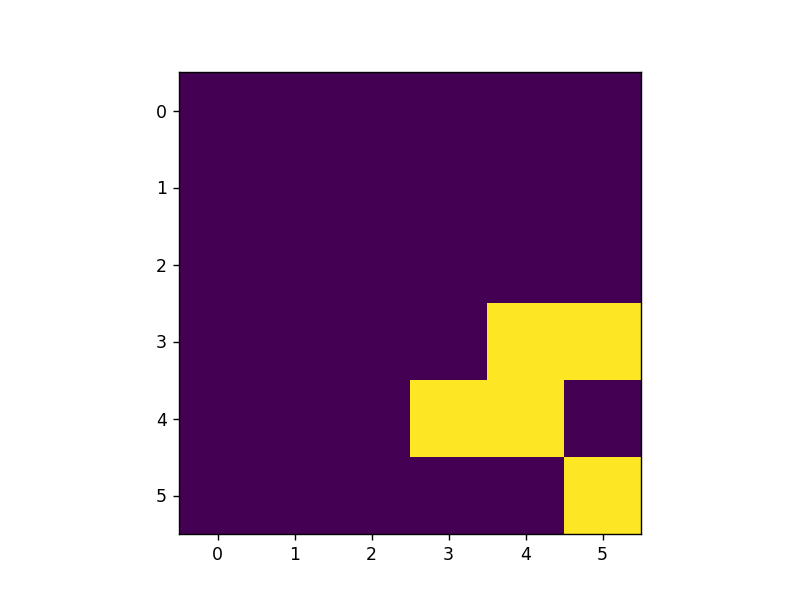

In [25]:
def simulate_glider_1():
    grid = np.array([
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 1],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0],
    ], dtype='uint8')
    
    return run_simulation(grid, 24, True)
    
history_glider_1 = simulate_glider_1()
animation_glider_1 = animate_simulation(
    "animation_glider_1", history_glider_1, framerate_medium, gif_writer_medium, save_file
)

<IPython.core.display.Javascript object>


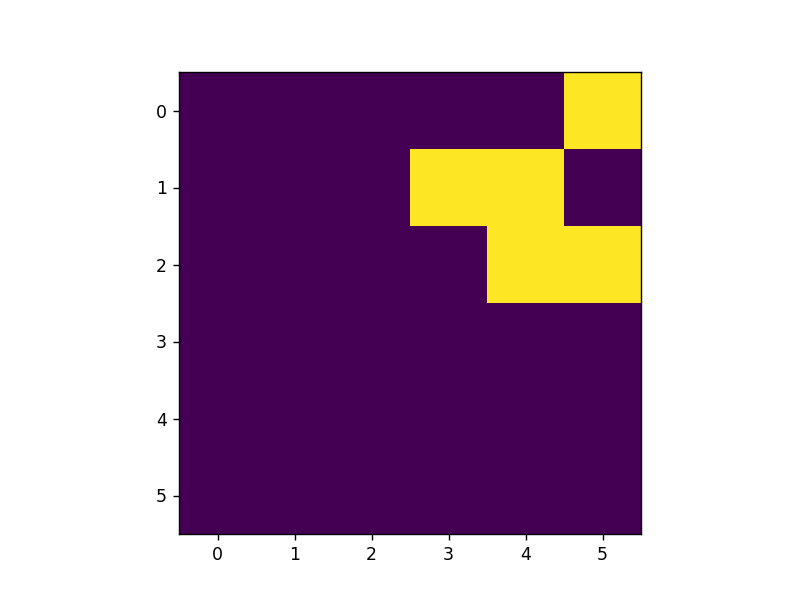

In [26]:
def simulate_glider_2():
    grid = np.array([
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
    ], dtype='uint8')
    
    return run_simulation(grid, 24, True)
    
history_glider_2 = simulate_glider_2()
animation_glider_2 = animate_simulation(
    "animation_glider_2", history_glider_2, framerate_medium, gif_writer_medium, save_file
)

<IPython.core.display.Javascript object>


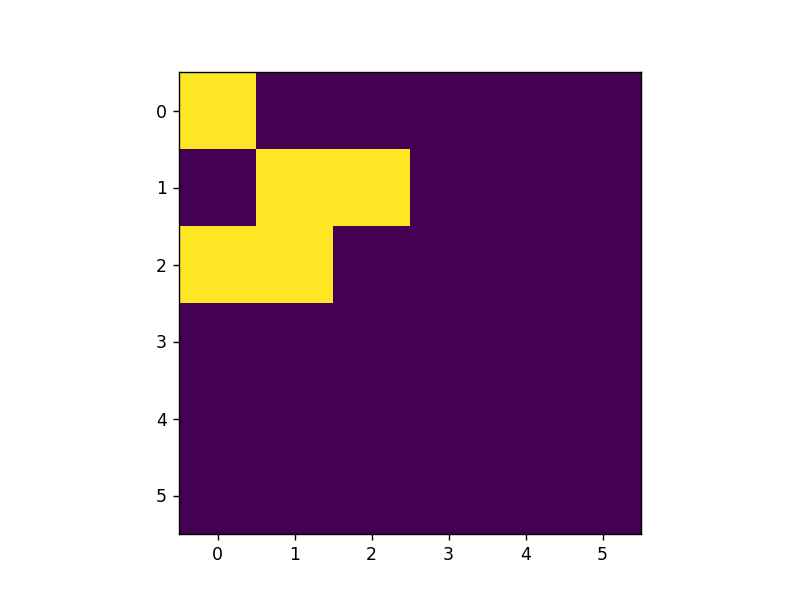

In [27]:
def simulate_glider_3():
    grid = np.array([
        [0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [1, 1, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
    ], dtype='uint8')
    
    return run_simulation(grid, 24, True)
    
history_glider_3 = simulate_glider_3()
animation_glider_3 = animate_simulation(
    "animation_glider_3", history_glider_3, framerate_medium, gif_writer_medium, save_file
)

<IPython.core.display.Javascript object>


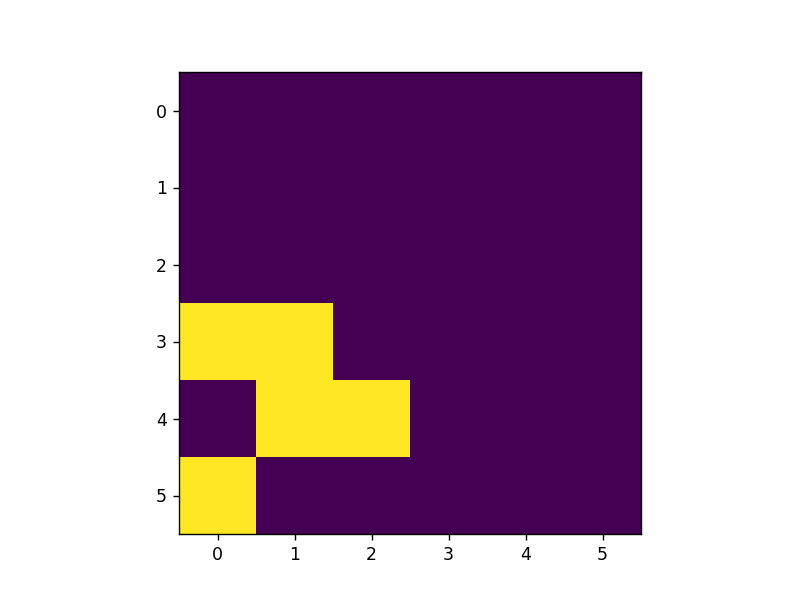

In [28]:
def simulate_glider_4():
    grid = np.array([
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
    ], dtype='uint8')
    
    return run_simulation(grid, 24, True)
    
history_glider_4 = simulate_glider_4()
animation_glider_4 = animate_simulation(
    "animation_glider_4", history_glider_4, framerate_medium, gif_writer_medium, save_file
)

## Exercise 4.6

In [29]:
def generate_config(rng, config_size):
    config_h, config_w = config_size
    inner_size = (config_h - 2, config_w - 2)
    max_seed = inner_size[0] * inner_size[1]
    
    config_seed = rng.integers(1, 2**max_seed)
    inner_config = decimal_to_binary_array(config_seed, width=max_seed).reshape(inner_size)

    config = np.zeros(shape=config_size)
    config[1:-1, 1:-1] = inner_config
    
    return config


def find_pattern_in_grid(rng, config_size, max_gen, rule_set=None):
    config = generate_config(rng, config_size)

    grid_size = (3*config_size[0], 3*config_size[1]) 
    grid = np.zeros(shape=grid_size, dtype='uint8')
    start_pos = config_size
    grid[start_pos[0]:start_pos[0]+config_size[0],
         start_pos[1]:start_pos[1]+config_size[1]] = config
    
    initial_grid = grid
    
    
    for gen in range(1, max_gen):
        grid = update_grid(grid, grid_size, False, rule_set)
            
        pos = find_config_shift(grid, config, config_size)
        if pos:
            shift = (pos[0]-start_pos[0], pos[1]-start_pos[1])
            return gen, shift, config, initial_grid, grid
    
    return None


def shift_config(grid, config_pos, config_size, shift):
    y, x = config_pos
    h, w = config_size
    dy, dx = shift
    config = grid[y:y+h, x:x+w]

    grid[y:y+h, x:x+w] = 0
    grid[y+dy:y+dy+h, x+dx:x+dx+w] = config

    return grid


def find_config_shift(grid, config, config_size): 
    h, w = config_size

    for y in range(0, 2*h):
        for x in range(0, 2*w):
            if np.array_equal(grid[y:y+h, x:x+w], config):
                return y, x

    return None


In [30]:
i_still = 0
i_oscillator = 1
i_glider = 2

def find_patterns(rng, n_tries, config_size, max_gen, rule_set=None):
    found_patterns = [[], [], []]
    found_identifiers = set()
    
    n_counts = [0, 0, 0]
    n_unique = [0, 0, 0]

    print("Looking for patterns...")
    for t in range(n_tries):
        if t%100 == 0:
            print(f"{t}/{n_tries}, counts={n_counts}, unique={n_unique}")

        found_info = find_pattern_in_grid(rng, config_size, max_gen, rule_set=rule_set)
        
        if found_info:
            gen, shift, *_ = found_info
            
            if shift != (0, 0):
                index = i_glider
            elif gen == 1:
                index = i_still
            else:
                index = i_oscillator
                
            n_counts[index] += 1
            
            identifier = (gen, shift)
            if identifier in found_identifiers:
                continue
            else:
                found_identifiers.add(identifier)

            n_unique[index] += 1
            found_patterns[index].append(found_info)

    if len(found_patterns) == 0:
        print("No pattern found")
    else:
        print(f"Finished! Found {len(found_patterns[i_still])} still-lifes, "
          f"{len(found_patterns[i_oscillator])} oscillators, and "
          f"{len(found_patterns[i_glider])} gliders.")
        
        print()
        print(f"Probability of still life: {n_counts[0] / n_tries}")
        print(f"Probability of oscillator: {n_counts[1] / n_tries}")
        print(f"Probability of glider: {n_counts[2] / n_tries}")
        print()
        print(f"Probability of unique: {sum(n_unique) / n_tries}")
        print(f"Probability of duplicate: {(sum(n_counts)-sum(n_unique))/n_tries}")
       
    return found_patterns, n_counts, n_unique


In [31]:
n_tries = 1000
config_size = 5, 5
max_gen = 8

found_patterns, n_counts, n_unique = find_patterns(rng, n_tries, config_size, max_gen)

Looking for patterns...
0/1000, counts=[0, 0, 0], unique=[0, 0, 0]
100/1000, counts=[3, 2, 3], unique=[1, 1, 2]
200/1000, counts=[5, 3, 7], unique=[1, 1, 4]
300/1000, counts=[8, 5, 11], unique=[1, 1, 4]
400/1000, counts=[12, 8, 15], unique=[1, 1, 4]
500/1000, counts=[13, 8, 18], unique=[1, 1, 4]
600/1000, counts=[14, 9, 22], unique=[1, 1, 4]
700/1000, counts=[15, 9, 24], unique=[1, 1, 4]
800/1000, counts=[16, 9, 26], unique=[1, 1, 4]
900/1000, counts=[19, 12, 30], unique=[1, 1, 4]
Finished! Found 1 still-lifes, 1 oscillators, and 4 gliders.

Probability of still life: 0.019
Probability of oscillator: 0.012
Probability of glider: 0.032

Probability of unique: 0.006
Probability of duplicate: 0.057


In [32]:
def plot_found_patterns(found_patterns, max_of_each=None):
    mixed_patterns = (
        found_patterns[i_still][:max_of_each] +
        found_patterns[i_oscillator][:max_of_each] +
        found_patterns[i_glider][:max_of_each]
    )
    
    if not len(mixed_patterns):
        return

    fig, axes = plt.subplots(len(mixed_patterns), 2, figsize=(7, 17))
    fig.tight_layout()
    
    for i, (gen, shift, config, initial_grid, grid) in enumerate(mixed_patterns):    
        if axes.shape == (2,):
            ax1, ax2 = axes
        else:
            ax1, ax2 = axes[i, :]
        ax1.imshow(initial_grid)
        ax1.set_title("Initial (dx=0, dy=0, gen=0)")
        ax2.imshow(grid)
        ax2.set_title(f"Shifted (dx={shift[1]}, dy={shift[0]}, gen={gen})")


<IPython.core.display.Javascript object>


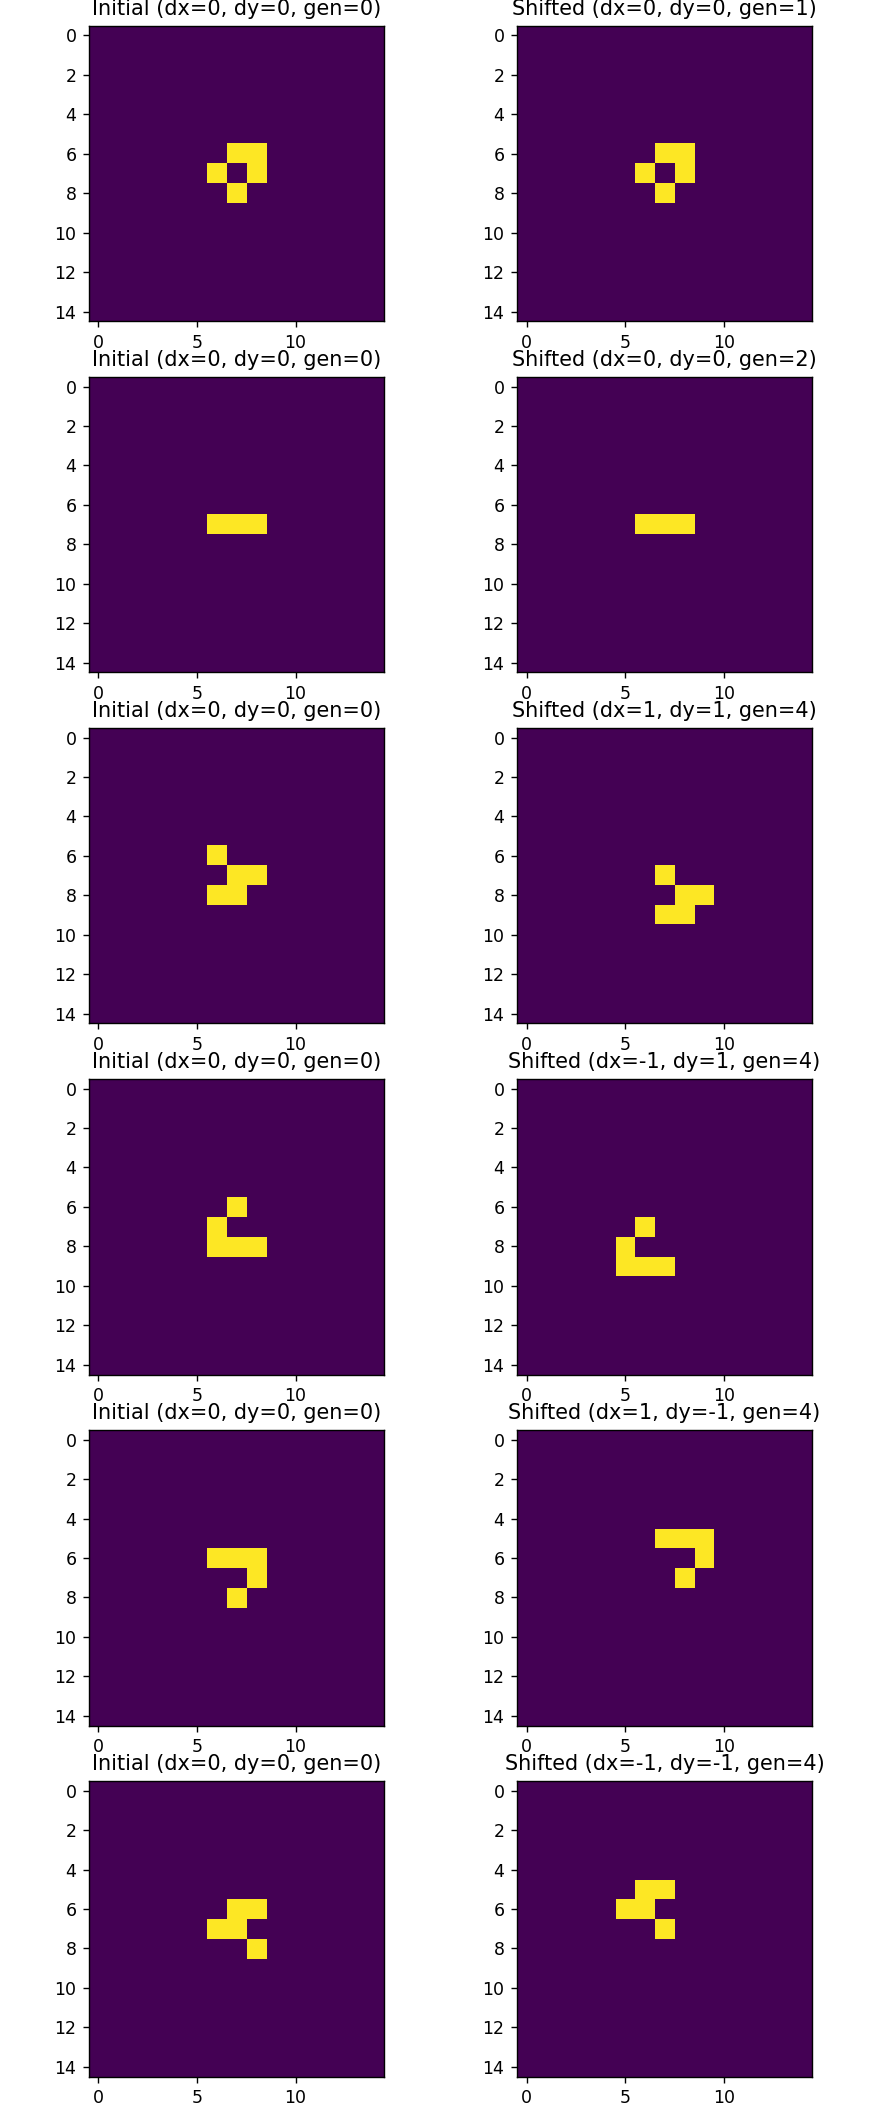

In [33]:
plot_found_patterns(found_patterns)

The function is quite ineffecient for finding new patterns since it samples randomly, which results in many duplicates.
A better way could be to only use unique seeds. Create a list of random and unique seeds and use every single one from it.

## Exercise 4.7

In [34]:
def generate_rule_set(rng, dead_seed, live_seed):
    rule_set = np.zeros((2, 9))
    
    rule_set[0] = (decimal_to_binary_array(dead_seed, 9) 
                   if dead_seed
                   else rng.integers(0, 2, (9,)))
    
    rule_set[1] = (decimal_to_binary_array(live_seed, 9)
                  if live_seed
                  else rng.integers(0, 2, (9,)))
    
    return rng.integers(0, 2, (2, 9))

Looking for patterns...
0/1000, counts=[0, 0, 0], unique=[0, 0, 0]
100/1000, counts=[0, 1, 44], unique=[0, 1, 10]
200/1000, counts=[0, 3, 90], unique=[0, 2, 10]
300/1000, counts=[0, 6, 130], unique=[0, 2, 10]
400/1000, counts=[0, 9, 180], unique=[0, 2, 10]
500/1000, counts=[0, 13, 213], unique=[0, 3, 10]
600/1000, counts=[0, 15, 257], unique=[0, 3, 10]
700/1000, counts=[0, 17, 299], unique=[0, 3, 10]
800/1000, counts=[0, 18, 347], unique=[0, 3, 10]
900/1000, counts=[0, 19, 389], unique=[0, 3, 10]
Finished! Found 0 still-lifes, 3 oscillators, and 10 gliders.

Probability of still life: 0.0
Probability of oscillator: 0.022
Probability of glider: 0.432

Probability of unique: 0.013
Probability of duplicate: 0.441


C:\Users\gaspa\AppData\Local\Temp\ipykernel_45900\2689297507.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(len(mixed_patterns), 2, figsize=(7, 17))


<IPython.core.display.Javascript object>


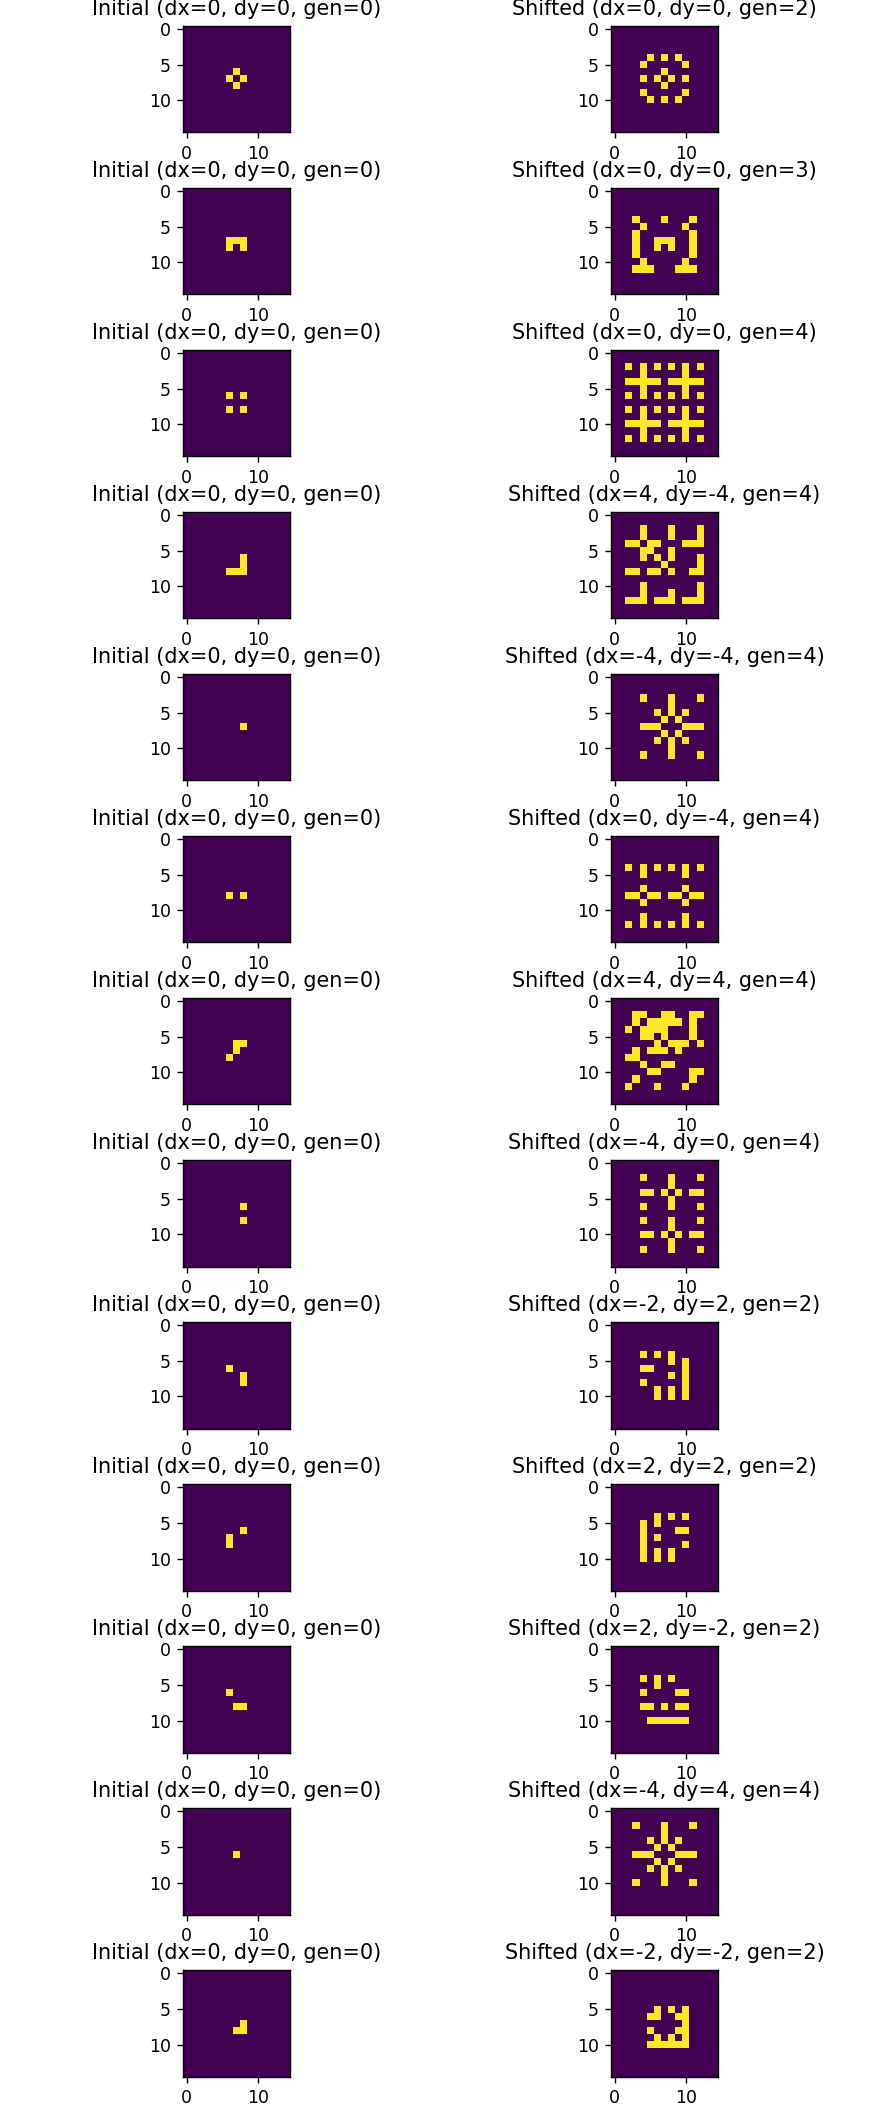

In [35]:
rule_set = generate_rule_set(rng, 300, 250)
n_tries = 1000
config_size = 5, 5
max_gen = 8

found_patterns, n_counts, n_unique = find_patterns(rng, n_tries, config_size, max_gen, rule_set=rule_set)
plot_found_patterns(found_patterns)

Looking for patterns...
0/1000, counts=[0, 0, 0], unique=[0, 0, 0]
100/1000, counts=[0, 0, 11], unique=[0, 0, 4]
200/1000, counts=[0, 0, 22], unique=[0, 0, 6]
300/1000, counts=[0, 0, 28], unique=[0, 0, 7]
400/1000, counts=[0, 0, 36], unique=[0, 0, 7]
500/1000, counts=[0, 0, 48], unique=[0, 0, 7]
600/1000, counts=[0, 0, 57], unique=[0, 0, 8]
700/1000, counts=[0, 0, 64], unique=[0, 0, 8]
800/1000, counts=[0, 0, 72], unique=[0, 0, 8]
900/1000, counts=[0, 0, 78], unique=[0, 0, 8]
Finished! Found 0 still-lifes, 0 oscillators, and 8 gliders.

Probability of still life: 0.0
Probability of oscillator: 0.0
Probability of glider: 0.085

Probability of unique: 0.008
Probability of duplicate: 0.077


<IPython.core.display.Javascript object>


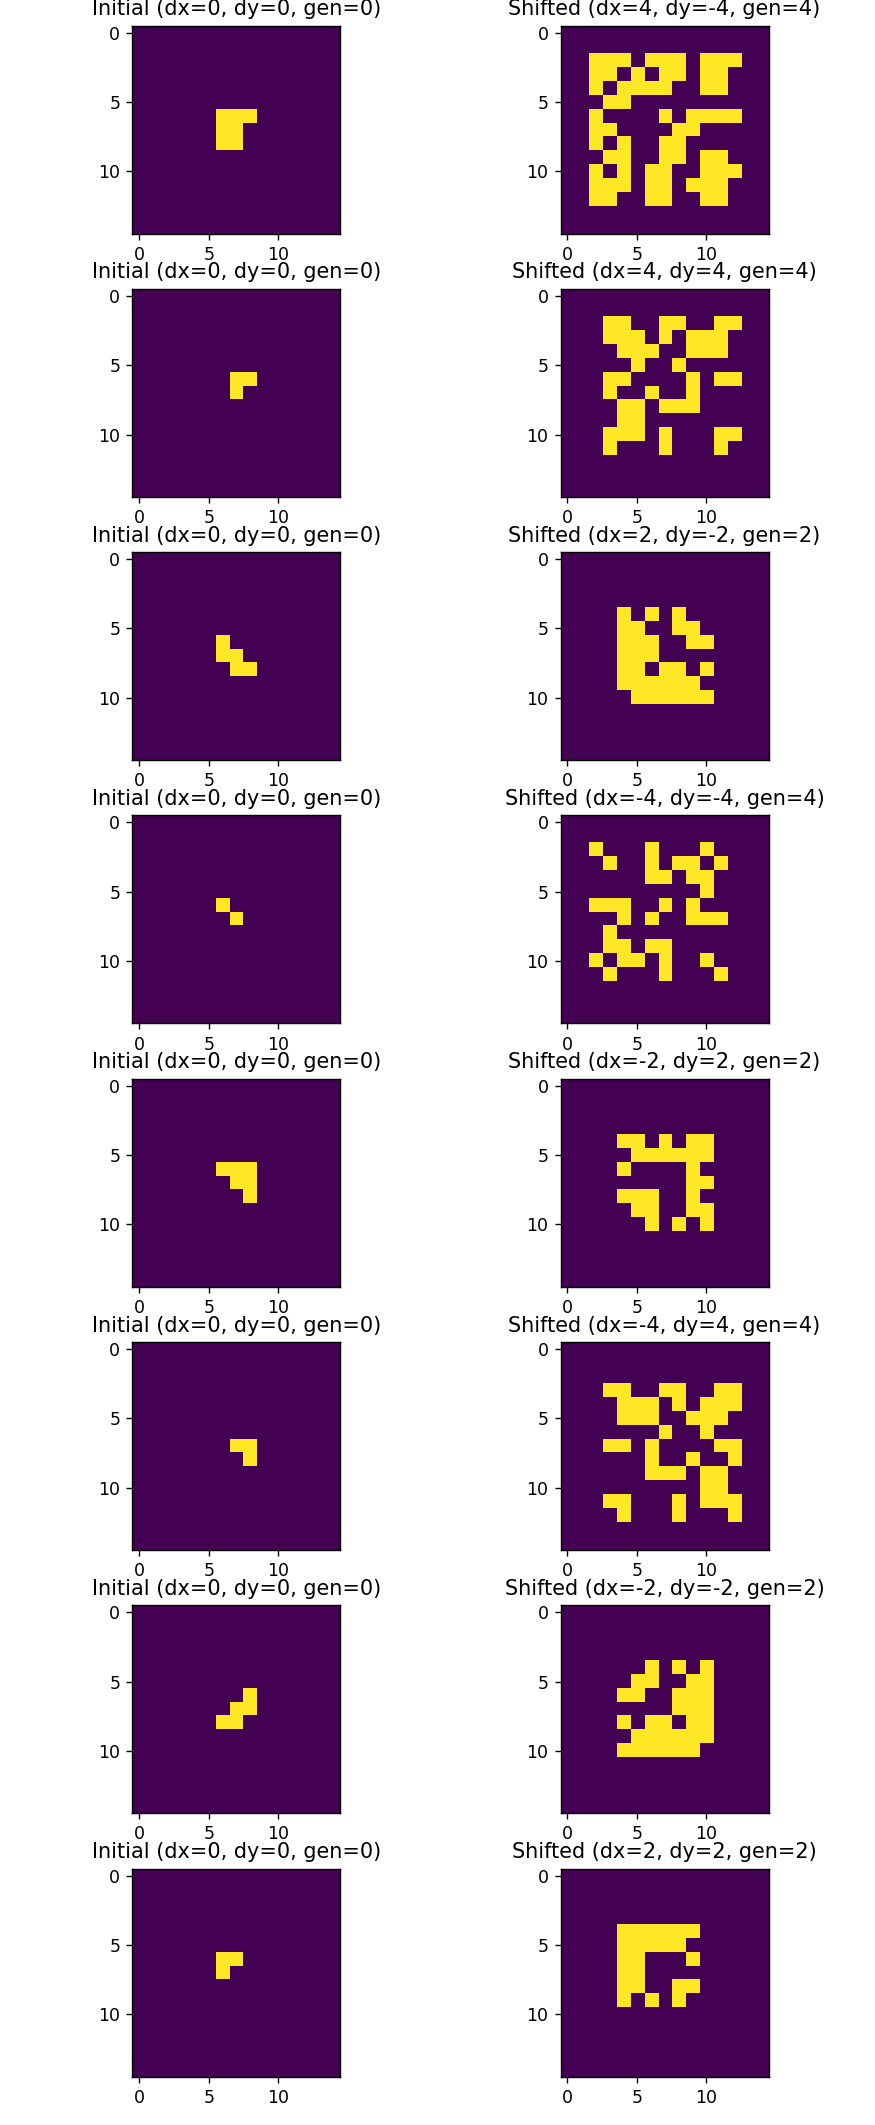

In [36]:
rule_set = generate_rule_set(rng, 259, 421)
n_tries = 1000
config_size = 5, 5
max_gen = 8

found_patterns, n_counts, n_unique = find_patterns(rng, n_tries, config_size, max_gen, rule_set=rule_set)
plot_found_patterns(found_patterns)

Looking for patterns...
0/1000, counts=[0, 0, 0], unique=[0, 0, 0]
100/1000, counts=[6, 1, 0], unique=[1, 1, 0]
200/1000, counts=[19, 1, 0], unique=[1, 1, 0]
300/1000, counts=[32, 6, 0], unique=[1, 1, 0]
400/1000, counts=[38, 9, 0], unique=[1, 1, 0]
500/1000, counts=[49, 11, 0], unique=[1, 1, 0]
600/1000, counts=[55, 15, 0], unique=[1, 1, 0]
700/1000, counts=[60, 15, 0], unique=[1, 1, 0]
800/1000, counts=[64, 15, 0], unique=[1, 1, 0]
900/1000, counts=[75, 19, 0], unique=[1, 1, 0]
Finished! Found 1 still-lifes, 1 oscillators, and 0 gliders.

Probability of still life: 0.078
Probability of oscillator: 0.023
Probability of glider: 0.0

Probability of unique: 0.002
Probability of duplicate: 0.099


<IPython.core.display.Javascript object>


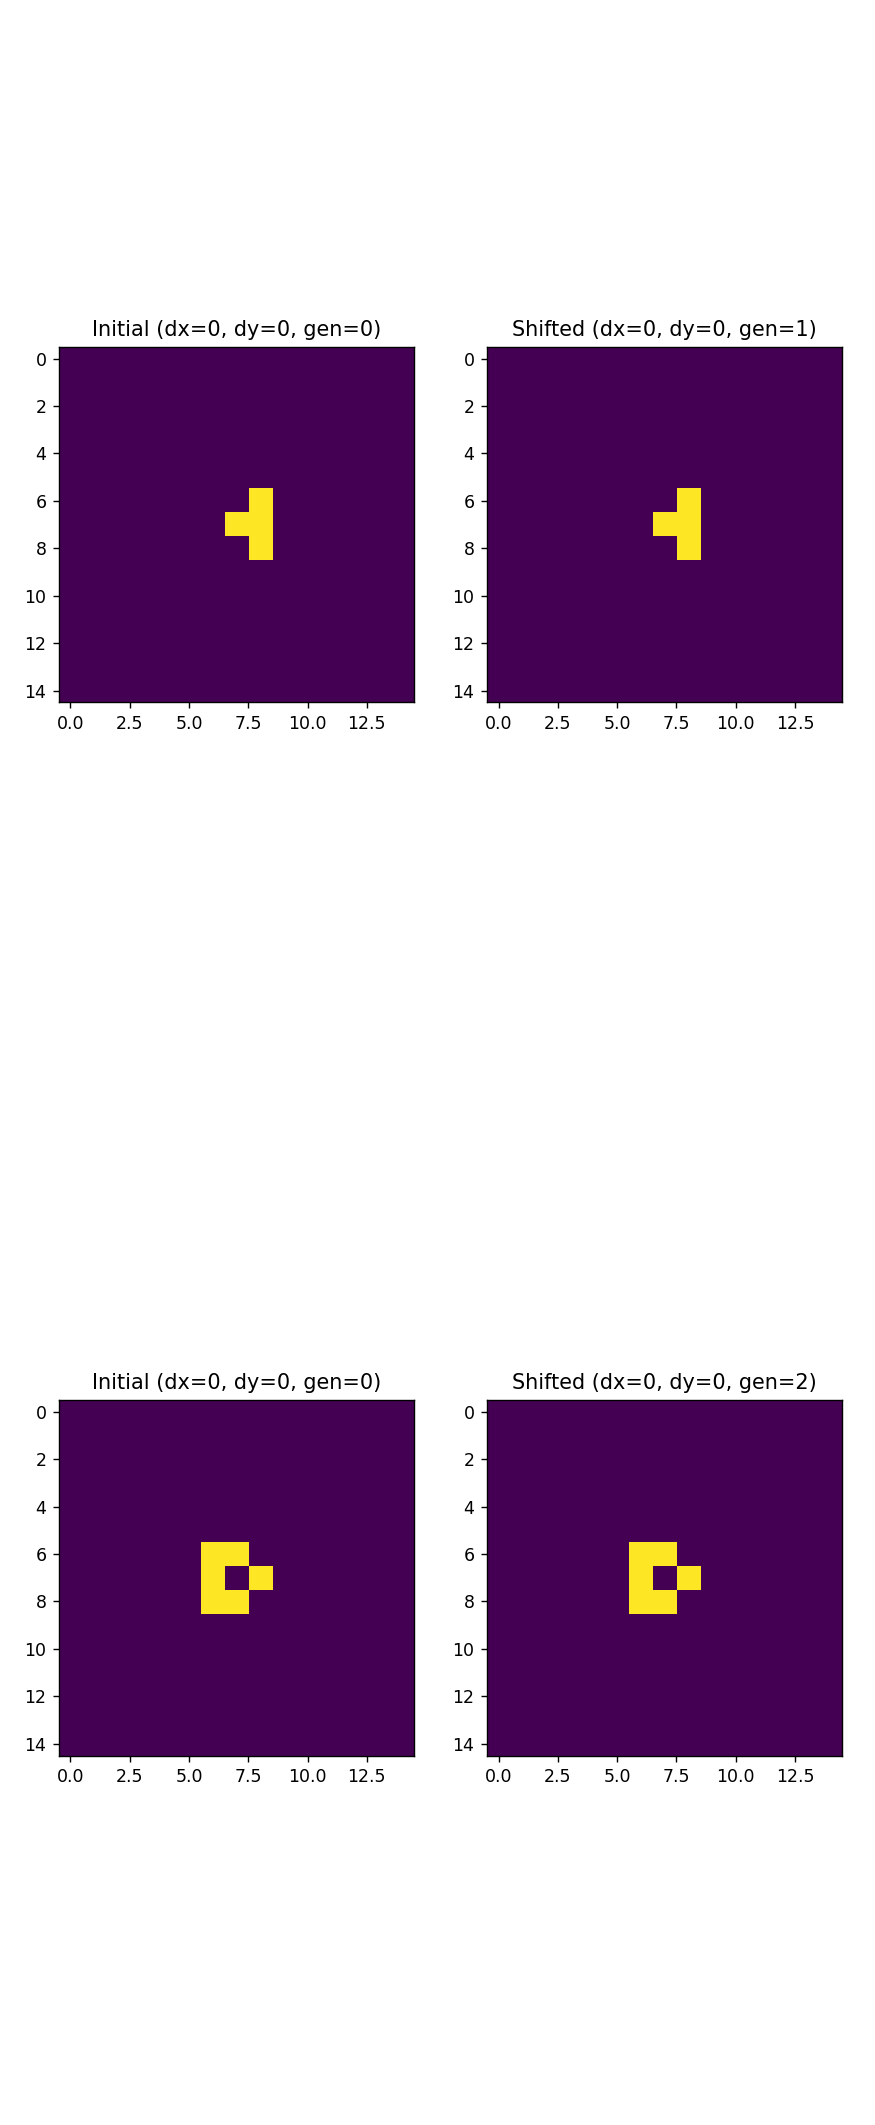

In [37]:
rule_set = generate_rule_set(rng, 132, 235)
n_tries = 1000
config_size = 5, 5
max_gen = 8

found_patterns, n_counts, n_unique = find_patterns(rng, n_tries, config_size, max_gen, rule_set=rule_set)
plot_found_patterns(found_patterns)

In [38]:
rule_set = generate_rule_set(rng, 412, 23)
n_tries = 1000
config_size = 5, 5
max_gen = 8

found_patterns, n_counts, n_unique = find_patterns(rng, n_tries, config_size, max_gen, rule_set=rule_set)
plot_found_patterns(found_patterns)

Looking for patterns...
0/1000, counts=[0, 0, 0], unique=[0, 0, 0]
100/1000, counts=[0, 0, 0], unique=[0, 0, 0]
200/1000, counts=[0, 0, 0], unique=[0, 0, 0]
300/1000, counts=[0, 0, 0], unique=[0, 0, 0]
400/1000, counts=[0, 0, 0], unique=[0, 0, 0]
500/1000, counts=[0, 0, 0], unique=[0, 0, 0]
600/1000, counts=[0, 0, 0], unique=[0, 0, 0]
700/1000, counts=[0, 0, 0], unique=[0, 0, 0]
800/1000, counts=[0, 0, 0], unique=[0, 0, 0]
900/1000, counts=[0, 0, 0], unique=[0, 0, 0]
Finished! Found 0 still-lifes, 0 oscillators, and 0 gliders.

Probability of still life: 0.0
Probability of oscillator: 0.0
Probability of glider: 0.0

Probability of unique: 0.0
Probability of duplicate: 0.0


## Exercise 4.8

In [39]:
def generate_grid_with_p(rng, grid_size, prob):
    return (rng.random(grid_size) < prob).astype('uint8')


In [40]:
def simulate_majority_rule_for_prob(rng, grid_size, prob, fig, axes):
    rule_set = np.array([[0, 0, 0, 0, 0, 1, 1, 1, 1],
                         [0, 0, 0, 0 ,1, 1, 1, 1, 1]], dtype='uint8')

    grid = initial_grid = generate_grid_with_p(rng, grid_size, prob)
    seen_states = set()

    max_gen = 1000
    final_gen = -1
    for gen in range(1, max_gen):
        if gen % 10 == 0:
            print(f"{gen}/{max_gen}")

        grid = update_grid(grid, grid.shape, False, rule_set=rule_set)
        grid_hash = tuple(grid.flatten())

        if grid_hash in seen_states:
            print(f"Steady state reached after {gen} iterations")
            final_gen = gen
            break

        seen_states.add(grid_hash)

    if final_gen == -1:
        print("No steady state found")
        fig = plt.figure()
        plt.imshow(grid)
        return
        
    ax1, ax2 = axes
    #fig = plt.figure()
    #fig.suptitle(f"gen={final_gen}, p={prob}")
    ax1.imshow(initial_grid)
    ax2.imshow(grid)
    ax1.title.set_text(f"prob={prob}")
    ax2.title.set_text(f"gen={final_gen}")

<IPython.core.display.Javascript object>


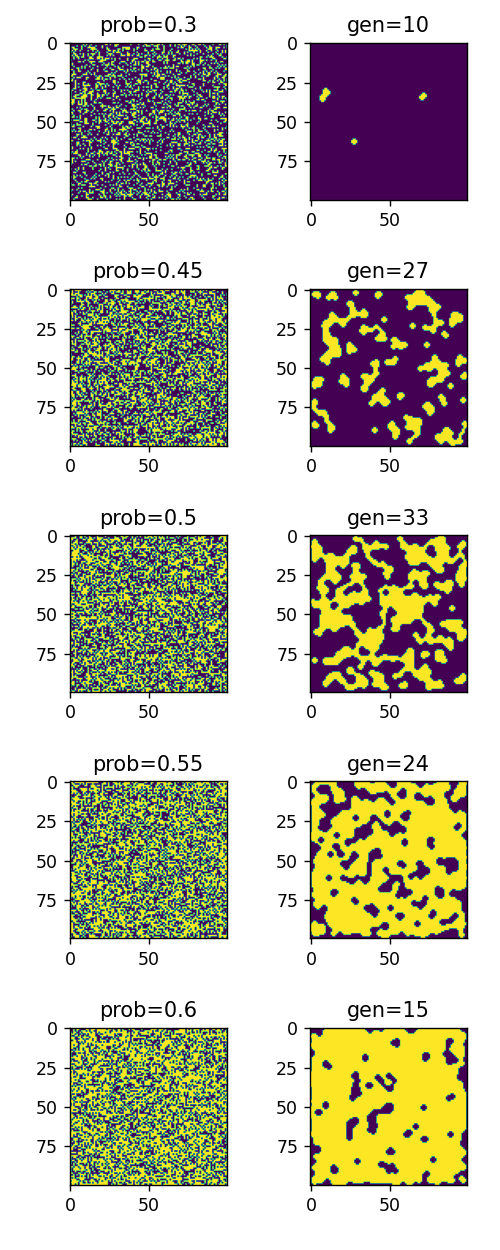

10/1000
Steady state reached after 10 iterations
10/1000
20/1000
Steady state reached after 27 iterations
10/1000
20/1000
30/1000
Steady state reached after 33 iterations
10/1000
20/1000
Steady state reached after 24 iterations
10/1000
Steady state reached after 15 iterations


In [41]:
grid_size = (100, 100)
probs = [0.3, 0.45, 0.5, 0.55, 0.6]
fig, axes = plt.subplots(len(probs), 2, figsize=(4, 10))
fig.tight_layout()

for i, prob in enumerate(probs):
    simulate_majority_rule_for_prob(rng, grid_size, prob, fig, axes[i])


## Finalizing

In [43]:
!pip install nbconvert[webpdf]

In [45]:
!jupyter nbconvert --to webpdf --allow-chromium-download homework-1.ipynb

[NbConvertApp] Converting notebook homework-1.ipynb to webpdf
[NbConvertApp] Building PDF
[INFO] Starting Chromium download.

  0%|          | 0.00/137M [00:00<?, ?b/s]
  1%|          | 963k/137M [00:00<00:14, 9.62Mb/s]
  2%|1         | 2.09M/137M [00:00<00:12, 10.6Mb/s]
  2%|2         | 3.22M/137M [00:00<00:12, 10.9Mb/s]
  3%|3         | 4.36M/137M [00:00<00:11, 11.1Mb/s]
  4%|4         | 5.51M/137M [00:00<00:11, 11.2Mb/s]
  5%|4         | 6.64M/137M [00:00<00:11, 11.2Mb/s]
  6%|5         | 7.77M/137M [00:00<00:11, 11.2Mb/s]
  7%|6         | 8.91M/137M [00:00<00:11, 11.3Mb/s]
  7%|7         | 10.0M/137M [00:00<00:11, 11.3Mb/s]
  8%|8         | 11.2M/137M [00:01<00:11, 11.3Mb/s]
  9%|9         | 12.3M/137M [00:01<00:11, 11.3Mb/s]
 10%|9         | 13.5M/137M [00:01<00:11, 11.2Mb/s]
 11%|#         | 14.7M/137M [00:01<00:10, 11.4Mb/s]
 12%|#1        | 15.8M/137M [00:01<00:10, 11.3Mb/s]
 12%|#2        | 16.9M/137M [00:01<00:10, 11.3Mb/s]
 13%|#3        | 18.1M/137M [00:01<00:10, 11.3Mb/s]
